In [2]:
# Initial imports
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import pickle
from imblearn.over_sampling import SMOTE

# Needed for visualisation
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import tree
import pydotplus
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

## Loading and Preprocessing Loans Encoded Data

In [3]:
# Read the dataset file with the Pandas 
dataset_df = pd.read_csv("../Outputs/Dataset/Employee_attrition.csv")

# Display the dataframe
dataset_df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel Rarely       1102                   Sales   
1   49        No  Travel Frequently        279  Research & Development   
2   37       Yes      Travel Rarely       1373  Research & Development   
3   33        No  Travel Frequently       1392  Research & Development   
4   27        No      Travel Rarely        591  Research & Development   

   DistanceFromHome      Education EducationField EnvironmentSatisfaction  \
0                 1        College  Life Sciences                  Medium   
1                 8  Below College  Life Sciences                    High   
2                 2        College          Other               Very High   
3                 3         Master  Life Sciences               Very High   
4                 2  Below College        Medical                     Low   

   Gender  ...  PerformanceRating RelationshipSatisfaction  StockOptionLevel  \
0  Female  ...          Excellent                      Low                 0   
1    Male  ...        Outstanding                Very High                 1   
2    Male  ...          Excellent                   Medium                 0   
3  Female  ...          Excellent                     High                 0   
4    Male  ...          Excellent                Very High                 1   

  TotalWorkingYears TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                 8                     0             Bad               6   
1                10                     3          Better              10   
2                 7                     3          Better               0   
3                 8                     3          Better               8   
4                 6                     3          Better               2   

   YearsInCurrentRole  YearsSinceLastPromotion YearsWithCurrManager  
0                   4                        0                    5  
1                   7                        1                    7  
2                   0                        0                    0  
3                   7                        3                    0  
4                   2                        2                    2  

[5 rows x 31 columns]

In [4]:
# Encode categorical variables
encoders = {}
for column in dataset_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_df[column] = le.fit_transform(dataset_df[column])
    encoders[column] = le

In [5]:
for column, encoder in encoders.items():
    with open (f'../Outputs/Label_Encoders/{column}_label_encoder.pkl', 'wb') as file:
        pickle.dump(encoder, file)

In [6]:
# Display the dataset after encoding
dataset_df.head()

Age  Attrition  BusinessTravel  DailyRate  Department  DistanceFromHome  \
0   41          1               2       1102           2                 1   
1   49          0               1        279           1                 8   
2   37          1               2       1373           1                 2   
3   33          0               1       1392           1                 3   
4   27          0               2        591           1                 2   

   Education  EducationField  EnvironmentSatisfaction  Gender  ...  \
0          2               1                        2       0  ...   
1          1               1                        0       1  ...   
2          2               4                        3       1  ...   
3          4               1                        3       0  ...   
4          1               3                        1       1  ...   

   PerformanceRating  RelationshipSatisfaction  StockOptionLevel  \
0                  0                         1                 0   
1                  1                         3                 1   
2                  0                         2                 0   
3                  0                         0                 0   
4                  0                         3                 1   

   TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
0                  8                      0                0               6   
1                 10                      3                2              10   
2                  7                      3                2               0   
3                  8                      3                2               8   
4                  6                      3                2               2   

   YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                   4                        0                     5  
1                   7                        1                     7  
2                   0                        0                     0  
3                   7                        3                     0  
4                   2                        2                     2  

[5 rows x 31 columns]

In [7]:
# Define features set
X = dataset_df.copy()
X = X.drop(columns= ['Attrition'],axis=1)
X.head()


Age  BusinessTravel  DailyRate  Department  DistanceFromHome  Education  \
0   41               2       1102           2                 1          2   
1   49               1        279           1                 8          1   
2   37               2       1373           1                 2          2   
3   33               1       1392           1                 3          4   
4   27               2        591           1                 2          1   

   EducationField  EnvironmentSatisfaction  Gender  HourlyRate  ...  \
0               1                        2       0          94  ...   
1               1                        0       1          61  ...   
2               4                        3       1          92  ...   
3               1                        3       0          56  ...   
4               3                        1       1          40  ...   

   PerformanceRating  RelationshipSatisfaction  StockOptionLevel  \
0                  0                         1                 0   
1                  1                         3                 1   
2                  0                         2                 0   
3                  0                         0                 0   
4                  0                         3                 1   

   TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
0                  8                      0                0               6   
1                 10                      3                2              10   
2                  7                      3                2               0   
3                  8                      3                2               8   
4                  6                      3                2               2   

   YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                   4                        0                     5  
1                   7                        1                     7  
2                   0                        0                     0  
3                   7                        3                     0  
4                   2                        2                     2  

[5 rows x 30 columns]

In [8]:
# Define target vector
y = dataset_df['Attrition']
y[:5]

0    1
1    0
2    1
3    0
4    0
Name: Attrition, dtype: int64

In [9]:
# Balance the Dataset
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
print("Before Smoote" , y.value_counts())
print()
print("After Smoote" , y_smote.value_counts())

Before Smoote Attrition
0    1233
1     237
Name: count, dtype: int64

After Smoote Attrition
1    1233
0    1233
Name: count, dtype: int64


## Splitting the dataset

In [10]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote.ravel(), random_state=1)

## Hyperparameters Tuning

In [11]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [12]:
# Create a random forest classifier
random_forest_model = RandomForestClassifier(random_state=1)

In [13]:
# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

In [14]:
# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] 

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [15]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

Best Parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.9172419962533414


## Creating optimal Random Forest model

In [16]:
# Creating optimal Random Forest model
optimized_random_forest_model = RandomForestClassifier(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    bootstrap = best_params['bootstrap'],
    random_state = 1
)

## Fitting Random Forest model

In [17]:
# Fitting the model
optimized_random_forest_model = optimized_random_forest_model.fit(X_train, y_train)

## Making Predictions Using the Random Forest Model

In [18]:
# Making predictions using the testing data
random_forest_predictions = optimized_random_forest_model.predict(X_test)

## Random Forest Evaluation

Predicted 0  Predicted 1
Actual 0          282           15
Actual 1           45          275

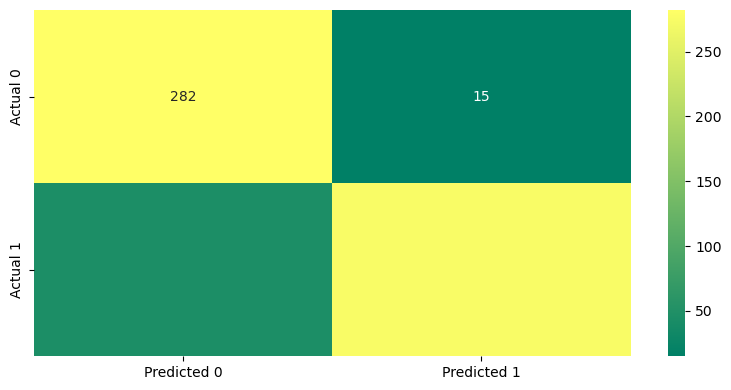

In [19]:
# Calculating the confusion matrix
plt.figure(figsize=(8,4))

cm = confusion_matrix(y_test, random_forest_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

display(cm_df)

sns.heatmap(cm_df,annot=True, fmt="g",cmap="summer")
plt.tight_layout()

plt.savefig("../Outputs/Machine_Learning_Models/optimized_random_forest_confusion_matrix.png")

plt.show()

In [20]:
# Calculating the accuracy score
random_forest_accuracy_score = accuracy_score(y_test, random_forest_predictions)

print(f"Accuracy Score is: {random_forest_accuracy_score}")


Accuracy Score is: 0.9027552674230146


In [21]:
# Classification Report
random_forest_clas_report = classification_report(y_test,  random_forest_predictions, target_names=['No Attrition', 'Attrition'])

print("Classification Report After Hyperparameters Tuning")
print("   ")
print(random_forest_clas_report)

Classification Report After Hyperparameters Tuning
   
              precision    recall  f1-score   support

No Attrition       0.86      0.95      0.90       297
   Attrition       0.95      0.86      0.90       320

    accuracy                           0.90       617
   macro avg       0.91      0.90      0.90       617
weighted avg       0.91      0.90      0.90       617



In [22]:
# Export as DOT file
estimator = optimized_random_forest_model.estimators_[1]
dot_data = tree.export_graphviz(estimator, out_file=None, feature_names=X_train.columns, rounded=True, proportion=False, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [23]:
# Random Forests in sklearn will automatically calculate feature importance
importances = optimized_random_forest_model.feature_importances_
# We can sort the features by their importance
sorted(zip(optimized_random_forest_model.feature_importances_, X.columns), reverse=True)

[(0.07314886380467647, 'StockOptionLevel'),
 (0.07068414786321124, 'JobSatisfaction'),
 (0.06095845737700989, 'MonthlyIncome'),
 (0.05534646372757854, 'EnvironmentSatisfaction'),
 (0.04475910056523281, 'YearsWithCurrManager'),
 (0.04379244318726316, 'MonthlyRate'),
 (0.04336536978126767, 'RelationshipSatisfaction'),
 (0.0424583606021177, 'JobLevel'),
 (0.04156239182887583, 'DailyRate'),
 (0.03810539974353748, 'Age'),
 (0.03744653090539322, 'TrainingTimesLastYear'),
 (0.037392492391257914, 'HourlyRate'),
 (0.03510886594840603, 'YearsInCurrentRole'),
 (0.03506335156998985, 'TotalWorkingYears'),
 (0.03351160995616313, 'DistanceFromHome'),
 (0.03164562463175108, 'WorkLifeBalance'),
 (0.029851483568636494, 'YearsAtCompany'),
 (0.028669686677146297, 'Education'),
 (0.024172253653192314, 'JobInvolvement'),
 (0.023728808690979993, 'EducationField'),
 (0.023034664243637256, 'PercentSalaryHike'),
 (0.022511089544165416, 'BusinessTravel'),
 (0.021569975810992112, 'JobRole'),
 (0.02084002987388893

<Axes: title={'center': 'Features Importances'}, ylabel='Features'>

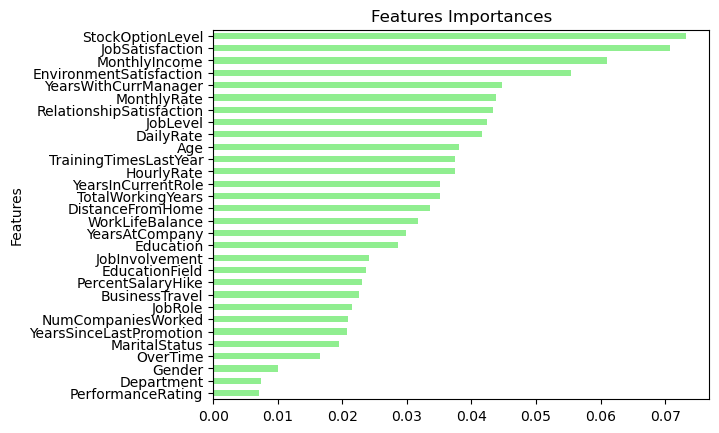

In [37]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(optimized_random_forest_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, ylabel='Features')

In [25]:
# Save the model
joblib.dump(optimized_random_forest_model, '../Outputs/Machine_Learning_Models/optimized_random_forest_model.pkl')

['../Outputs/Machine_Learning_Models/optimized_random_forest_model.pkl']